# Processing POI data from Liverpool

## Import packages

In [28]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import utilities
from compute_pairwise_distance import compute_pairwise_distance

## Read in POI data

In [29]:
# read the POI data
df_poi = pd.read_csv("Liverpool_hub_four_POI/poi_4565130/poi-extract-2022_03.csv", sep="|")

In [30]:
df_poi.columns

Index(['ref_no', 'name', 'pointx_class', 'feature_easting', 'feature_northing',
       'pos_accuracy', 'uprn', 'topo_toid', 'topo_toid_version', 'usrn',
       'usrn_mi', 'distance', 'address_detail', 'street_name', 'locality',
       'geographic_county', 'postcode', 'admin_boundary', 'telephone_number',
       'url', 'brand', 'qualifier_type', 'qualifier_data', 'provenance',
       'supply_date'],
      dtype='object')

In [31]:
df_poi_by_class = df_poi.pointx_class.value_counts().to_frame().reset_index().rename(columns={"index": "class", "pointx_class": "number"})
df_poi_by_class['class_4d'] = df_poi_by_class['class'].apply(lambda x: str(x)[-4:])

In [32]:
df_poi_by_class

,class,number,class_4d
0,10590732,536,0732
1,6340433,415,0433
2,1020034,383,0034
3,2100156,315,0156
4,1020018,247,0018
...,...,...,...
391,7370471,1,0471
392,7370495,1,0495
393,2090773,1,0773
394,6340462,1,0462


## Read in POI classifications and join the POI data with classifications

In [33]:
df_poi_class_table = pd.read_csv("Liverpool_hub_four_POI/poi_4565130/docs/POI_CLASSIFICATIONS.txt", sep = "|", dtype=object)
# .["Class Number","Classification Description"]
df_poi_class_table.columns

Index(['ID', 'Class Number', 'Classification Description',
       'Category Number Foreign Key'],
      dtype='object')

In [34]:
df_poi_by_class = pd.merge(how='left',
         left= df_poi_by_class, 
         right=df_poi_class_table, 
         left_on='class_4d', right_on='Class Number')

In [35]:
df_poi_by_class.head(50)

,class,number,class_4d,ID,Class Number,Classification Description,Category Number Foreign Key
0,10590732,536,0732,619,0732,BUS STOPS,59
1,6340433,415,0433,350,0433,ELECTRICAL FEATURES,34
2,1020034,383,0034,14,0034,"PUBS, BARS AND INNS",02
3,2100156,315,0156,118,0156,HAIR AND BEAUTY SERVICES,10
4,1020018,247,0018,10,0018,FAST FOOD AND TAKEAWAY OUTLETS,02
5,1020043,234,0043,15,0043,RESTAURANTS,02
6,3200269,231,0269,217,0269,UNSPECIFIED AND OTHER ATTRACTIONS,20
7,9470699,223,0699,536,0699,CONVENIENCE STORES AND INDEPENDENT SUPERMARKETS,47
8,1020013,215,0013,9,0013,"CAFES, SNACK BARS AND TEA ROOMS",02
9,2090141,166,0141,98,0141,CASH MACHINES,09


In [36]:
df_poi.shape
# 7693 POIs in total

(7693, 25)

## Selecting several types of POI as candidate sites for the case study

First, types of POIs used in the location-allocation analysis in Feng et al. 2021:

```
The U.S. Geological Survey maintains the National Structures Dataset that contains data on Fire/Police Stations, Hospital/Medical Centers, Ambulance Services, etc. We used this data in defining possible drone sites. Fig. 4 shows the 520 potential stations in the study area, among which the stations are selected to equip drones.

40 stations are selected to equip the drones.
```

We select the following types of POIs:
- 343|"0422"|"POLICE STATIONS"|"33"
- 337|"0414"|"FIRE BRIGADE STATIONS"|"33"
- 301|"0106"|"MEDICAL EQUIPMENT RENTAL AND LEASING"|"29"
- 302|"0356"|"AMBULANCE AND MEDICAL TRANSPORTATION SERVICES"|"29"
- 613|"0731"|"BUS AND COACH STATIONS, DEPOTS AND COMPANIES"|"57"
- 614|"0738"|"RAILWAY STATIONS, JUNCTIONS AND HALTS"|"57"
- 615|"0756"|"TRAM, METRO AND LIGHT RAILWAY STATIONS AND STOPS"|"57"
- 616|"0758"|"TAXI RANKS"|"57"
- 617|"0761"|"UNDERGROUND NETWORK STATIONS"|"57"
- 618|"0794"|"LONDON UNDERGROUND ENTRANCES"|"57"
- 247|"0293"|"GYMNASIUMS, SPORTS HALLS AND LEISURE CENTRES"|"24"
- 362|"0456"|"HALLS AND COMMUNITY CENTRES"|"34"

In [37]:
def check_number_POI(list_poi_class):
    print(df_poi[df_poi["pointx_class"].astype(str).str.contains('|'.join(list_poi_class))].shape[0])

In [38]:
# how many sites are in these types? Only 8
list_poi_class = ["0422","0414","0106","0356","0293", "0456"]

check_number_POI(list_poi_class)

93


This can be the case study: **SELECT 10 out of 93 candidate sites in the p-median problem (PMP).**

In [39]:
# visualise the map of these POIs
list_poi_class = ["0422","0414","0106","0356","0293", "0456"]
df_poi_subset = df_poi[df_poi["pointx_class"].astype(str).str.contains('|'.join(list_poi_class))]

In [40]:
print(df_poi_subset.columns)
print(df_poi_subset.shape[0])

Index(['ref_no', 'name', 'pointx_class', 'feature_easting', 'feature_northing',
       'pos_accuracy', 'uprn', 'topo_toid', 'topo_toid_version', 'usrn',
       'usrn_mi', 'distance', 'address_detail', 'street_name', 'locality',
       'geographic_county', 'postcode', 'admin_boundary', 'telephone_number',
       'url', 'brand', 'qualifier_type', 'qualifier_data', 'provenance',
       'supply_date'],
      dtype='object')
93


In [41]:
gdf_poi = gpd.GeoDataFrame(
    df_poi_subset, geometry=gpd.points_from_xy(df_poi_subset.feature_easting, df_poi_subset.feature_northing))
gdf_poi = gdf_poi.set_crs('epsg:27700')

In [42]:
# write gdf_poi to geojson
gdf_poi.to_file("Sites_Liverpool_hub_four.geojson", driver = 'GeoJSON')

In [43]:
# plot gdf_poi
# read the boundary of Liverpool Hub Four
gdf_liverpool_hub_four = gpd.read_file("Liverpool_hub_four_neighbourhood.geojson")
ax = gdf_liverpool_hub_four.plot(color='white', edgecolor='black')
gdf_poi.plot(ax=ax, color='red')
plt.title("Candidate sites in Liverpool Hub Four (93 sites)")

Text(0.5, 1.0, 'Candidate sites in Liverpool Hub Four (93 sites)')

## Calculate distance matrix

In [44]:
# read in street segments
gdf_street_segments = gpd.read_file("nkde_crime_Liverpool_hub_four.geojson")

In [45]:
gdf_street_segments.crs

<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [46]:
# add demand_id
gdf_street_segments["demand_id"] = np.arange(len(gdf_street_segments))
# add feature_easting and feature_northing from geometry data
gdf_street_segments["feature_easting"], gdf_street_segments["feature_northing"] = gdf_street_segments.geometry.x, gdf_street_segments.geometry.y
# transform to WGS84 
gdf_street_segments_wgs = gdf_street_segments.to_crs("epsg:4326")
gdf_street_segments["long"],gdf_street_segments["lat"] = gdf_street_segments_wgs.geometry.x, gdf_street_segments_wgs.geometry.y 

In [47]:
gdf_street_segments.to_file("nkde_crime_Liverpool_hub_four.geojson", driver = "GeoJSON")

In [48]:
# add a column of 'site_id' to gdf_poi. get a dataframe of lat, long, easting, northing
gdf_poi["site_id"] = np.arange(len(gdf_poi))
gdf_poi_wgs = gdf_poi.to_crs("epsg:4326")
gdf_poi["long"],gdf_poi["lat"] = gdf_poi_wgs.geometry.x, gdf_poi_wgs.geometry.y 

In [49]:
# write gdf_poi to geojson
gdf_poi.to_file("Sites_Liverpool_hub_four.geojson")

In [50]:
print(gdf_poi_wgs.geometry.x.head())
print(gdf_poi["long"].head())

142    -2.962924
143    -2.967434
1498   -2.915499
1505   -2.930719
2007   -2.977772
dtype: float64
142    -2.962924
143    -2.967434
1498   -2.915499
1505   -2.930719
2007   -2.977772
Name: long, dtype: float64


In [51]:
df_site = gdf_poi[["site_id", "long", "lat", "feature_easting", "feature_northing"]].rename(columns={"long":"site_long", "lat":"site_lat", "feature_easting":"site_easting", "feature_northing":"site_northing" })

In [52]:
df_demand = gdf_street_segments[["demand_id", "long", "lat", "feature_easting", "feature_northing"]].rename(columns={"long":"demand_long", "lat":"demand_lat", "feature_easting":"demand_easting", "feature_northing":"demand_northing" })

In [53]:
# cartesian product in pandas
df_distance = df_site.merge(df_demand, how='cross')
df_distance.columns

Index(['site_id', 'site_long', 'site_lat', 'site_easting', 'site_northing',
       'demand_id', 'demand_long', 'demand_lat', 'demand_easting',
       'demand_northing'],
      dtype='object')

In [54]:
print(df_site.shape[0])
print(df_demand.shape[0])
print(df_distance.shape[0] - df_site.shape[0]*df_demand.shape[0])

93
1710
0


### Euclidean distance

In [55]:
df_distance.dtypes

site_id              int64
site_long          float64
site_lat           float64
site_easting       float64
site_northing      float64
demand_id            int64
demand_long        float64
demand_lat         float64
demand_easting     float64
demand_northing    float64
dtype: object

In [32]:
df_distance['Euclidean'] = np.sqrt(np.square(df_distance.demand_easting - df_distance.site_easting) + 
                                   np.square(df_distance.demand_northing - df_distance.site_northing))

In [33]:
# test pivot_table
df_test = df_distance.iloc[:5,]

In [34]:
print(df_test)

   site_id  site_long   site_lat  site_easting  site_northing  demand_id  \
0        0  -2.962924  53.387355      336054.0       388267.0          0   
1        0  -2.962924  53.387355      336054.0       388267.0          1   
2        0  -2.962924  53.387355      336054.0       388267.0          2   
3        0  -2.962924  53.387355      336054.0       388267.0          3   
4        0  -2.962924  53.387355      336054.0       388267.0          4   

   demand_long  demand_lat  demand_easting  demand_northing    Euclidean  
0    -2.913968   53.394686   339320.415381    389039.829352  3356.595693  
1    -2.911148   53.394061   339507.021123    388967.900086  3523.438066  
2    -2.908332   53.393432   339693.431628    388895.457235  3693.294068  
3    -2.905632   53.392660   339871.898002    388807.293089  3855.938508  
4    -2.903148   53.391646   340035.599615    388692.461849  4004.266884  


In [35]:
df_test_pivot = pd.pivot_table(df_test, values='Euclidean', index=['site_id'],
                    columns=['demand_id'], aggfunc=np.sum)

In [36]:
df_test_pivot.columns

Int64Index([0, 1, 2, 3, 4], dtype='int64', name='demand_id')

In [37]:
df_distance.columns

Index(['site_id', 'site_long', 'site_lat', 'site_easting', 'site_northing',
       'demand_id', 'demand_long', 'demand_lat', 'demand_easting',
       'demand_northing', 'Euclidean'],
      dtype='object')

In [38]:
# The distance matrix required by spopt is a M*N matrix, with M rows and N columns corresponding to demands and sites
df_distance_pivot_Euclidean = pd.pivot_table(df_distance, values='Euclidean', index=['demand_id'],
                    columns=['site_id'], aggfunc=np.sum)

In [42]:
# save as Euclidean_distance_site_demand.csv
file_distance_Euclidean = 'distance_matrix_demand_site_Euclidean.csv'
df_distance_pivot_Euclidean.to_csv(file_distance_Euclidean)

In [58]:
# check this dataset - is it correct?
from scipy import stats
stats.describe(df_distance_pivot_Euclidean.to_numpy().flatten())

DescribeResult(nobs=159030, minmax=(6.857566107243913, 8363.349912077383), mean=2629.3906459657437, variance=2342088.4896041877, skewness=0.46472054949008373, kurtosis=-0.6030650967716884)

In [43]:
# read in this csv and transform it into an ndarray. 
array_distance_Eudlidean = utilities.read_distance_matrix_as_np_array(file_distance_Euclidean)
# array_distance_Eudlidean is a numpy array, with rows and columns corresponding to demands and sites, respectively

In [82]:
assert(array_distance_Eudlidean.shape == (1710, 93))

### Network distance

In [44]:
# the largest Euclidean distance
array_distance_Eudlidean.max().max()

8363.349912077383

In [45]:
print(df_site.columns)
print(df_demand.columns)

Index(['site_id', 'site_long', 'site_lat', 'site_easting', 'site_northing'], dtype='object')
Index(['demand_id', 'demand_long', 'demand_lat', 'demand_easting',
       'demand_northing'],
      dtype='object')


In [46]:
df_demand[['demand_id', 'demand_long', 'demand_lat']].__class__

pandas.core.frame.DataFrame

In [47]:
# using OSRM
cutoff_distance = 100000
df_distance_network = compute_pairwise_distance(df_demand[['demand_id', 'demand_long', 'demand_lat']], df_site[['site_id', 'site_long', 'site_lat']], cutoff_distance, False, True)


Progress bar:: 100%|██████████| 159030/159030 [17:23<00:00, 152.41it/s]


In [48]:
df_distance['network'] = df_distance_network.distance

In [49]:
# The distance matrix required by spopt is a M*N matrix, with M rows and N columns corresponding to demands and sites
df_distance_pivot_network = pd.pivot_table(df_distance, values='network', index=['demand_id'],
                    columns=['site_id'], aggfunc=np.max)

In [50]:
print(df_distance_pivot_network.index)
print(df_distance_pivot_network.columns)

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1700, 1701, 1702, 1703, 1704, 1705, 1706, 1707, 1708, 1709],
           dtype='int64', name='demand_id', length=1710)
Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
            68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
            85, 86, 87, 88, 89, 90, 91, 92],
           dtype='int64', name='site_id')


In [51]:
# save as distance_matrix_demand_site_network.csv
file_distance_network = 'distance_matrix_demand_site_network.csv'
df_distance_pivot_network.to_csv(file_distance_network)

In [57]:
# check this dataset - is it correct?
from scipy import stats
stats.describe(df_distance_pivot_network.to_numpy().flatten())

DescribeResult(nobs=159030, minmax=(0.4, 16771.3), mean=3644.056078098472, variance=3959168.731285362, skewness=0.9212967699052391, kurtosis=1.7169753266711023)

In [52]:
array_distance_Eudlidean = utilities.read_distance_matrix_as_np_array(file_distance_network)
assert(array_distance_Eudlidean.shape == (1710, 93))

### No-drone-zone-contrained Euclidean distance

In [59]:
# install PythonRobotics library
# !mkdir tmp_folder
# !git clone https://github.com/AtsushiSakai/PythonRobotics.git


Cloning into 'PythonRobotics'...
remote: Enumerating objects: 10682, done.
remote: Counting objects: 100% (201/201), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 10682 (delta 79), reused 188 (delta 74), pack-reused 10481
Receiving objects: 100% (10682/10682), 290.01 MiB | 13.25 MiB/s, done.
Resolving deltas: 100% (6055/6055), done.
Checking connectivity... done.


In [78]:
# !pip3 --no-cache-dir install raster2xyz

  Created wheel for raster2xyz: filename=raster2xyz-0.1.3-py3-none-any.whl size=5964 sha256=5abe0ac6650785232dc116567a9d3737c53195536157e9974875115a47b00fa2
  Stored in directory: /tmp/pip-ephem-wheel-cache-bbm7endx/wheels/07/4b/5d/fc666340cb735a7a79d149be0acd64dff8edec947dba612d70
Successfully built raster2xyz


### Download the DTM data

In [56]:
import raster2xyz
from raster2xyz.raster2xyz import Raster2xyz

In [81]:
# transform the geotiff file into csv. Note that this dataset is not used
# https://stackoverflow.com/a/64589687/4667568

[2022-05-31 02:58:08 - INFO] - Getting geotransform and data...
[2022-05-31 02:58:08 - INFO] - Getting XYZ data...
[2022-05-31 02:58:08 - INFO] - Getting geotransformed coordinates...
[2022-05-31 02:58:08 - INFO] - Building XYZ data...
[2022-05-31 02:58:09 - INFO] - New XYZ (csv file) created...


x    float64
y    float64
z    float64
dtype: object

In [57]:
def raster_to_csv(input_raster, out_csv):
    import raster2xyz
    from raster2xyz.raster2xyz import Raster2xyz
    rtxyz = Raster2xyz()
    rtxyz.translate(input_raster, out_csv)
    df_raster = pd.read_csv(out_csv)
    return(df_raster) 


In [121]:
%%bash
# extract the tif files from the zip files
cd DTM
for file in *.zip
do
tiff_file_name=$(echo $file | grep -oE 'SJ[[:alnum:]]+')_DTM_2m.tif
unzip -p $file $tiff_file_name > $tiff_file_name
done
# !unzip './DTM/LIDAR-DTM-2m-2020-SJ38ne.zip'

In [143]:
# merge the tiff files into DTM/DTM_merge.tif
!ls DTM/*.tif
!python gdal_merge.py -o DTM/DTM_merge.tif DTM/*.tif

DTM/SJ38ne_DTM_2m.tif  DTM/SJ38sw_DTM_2m.tif  DTM/SJ48nw_DTM_2m.tif
DTM/SJ38nw_DTM_2m.tif  DTM/SJ39se_DTM_2m.tif  DTM/SJ48sw_DTM_2m.tif
DTM/SJ38se_DTM_2m.tif  DTM/SJ39sw_DTM_2m.tif  DTM/SJ49sw_DTM_2m.tif
0...10...20...30...40...50...60...70...80...90...100 - done.


In [85]:
# the resolution is 2m, x_size = 7500, y_size = 7500
# resample to 20m?
from osgeo import gdal
from osgeo import gdalconst

# open reference file and get resolution
input_tiff = "DTM/DTM_merge.tif"
input_tiff = gdal.Open(input_tiff, 0)  # this opens the file in only reading mode
resolution = input_tiff.GetGeoTransform()
# see https://gdal.org/user/raster_data_model.html
# https://gdal.org/python/osgeo.gdal-module.html#WarpOptions
print("pixel width: {}".format(resolution[1]))
print("pixel height: {}".format(-resolution[5]))
# the X and Y resolution are 2m and 2m

pixel width: 2.0
pixel height: 2.0


In [103]:
x_res_new = resolution[1] * 10 # new resolution is 20m and 20m
y_res_new = -resolution[5] * 10  # make sure this value is positive

# specify input and output filenames
inputFile = "DTM/DTM_merge.tif"
outputFile = "DTM/DTM_merge_20m_20m.tif"

# call gdal Warp
kwargs = {"format": "GTiff", "xRes": x_res_new, "yRes": y_res_new, "resampleAlg": 'average'}
ds = gdal.Warp(outputFile, inputFile, **kwargs)

In [104]:
# check the new tiff and resample
from osgeo import gdal
raster_DTM = gdal.Open("DTM/DTM_merge_20m_20m.tif")
# number of raster bands
# print(raster_DTM.RasterCount)
print("Width: {}, Height: {}".format(raster_DTM.RasterXSize,raster_DTM.RasterYSize))
# print("crs: {}".format(raster_DTM.GetProjection()))
print("band count:", raster_DTM.RasterCount)


1
Width: 750, Height: 750
band count: 1


In [105]:
# check band statistics
# Read the raster band as separate variable
band = raster_DTM.GetRasterBand(1)
print(type(band))
print(band.ComputeStatistics(0))
print ("[ NO DATA VALUE ] = ", band.GetNoDataValue())
print(band.GetMinimum())
print(band.GetMaximum())
print(band.GetMetadata())

<class 'osgeo.gdal.Band'>
[0.0, 0.0, 0.0, 0.0]
[ NO DATA VALUE ] =  None
0.0
0.0
{'STATISTICS_MAXIMUM': '0', 'STATISTICS_MEAN': '0', 'STATISTICS_MINIMUM': '0', 'STATISTICS_STDDEV': '0'}


In [74]:
# transform the merged tiff into csv file
# df_dtm = raster_to_csv('DTM/DTM_merge.tif', 'DTM/DTM_merge.csv')
df_dtm = raster_to_csv('DTM/DTM_merge_20m_20m.tif', 'DTM/DTM_merge_20m_20m.csv')
gdal

[2022-06-01 10:09:30 - INFO] - Getting geotransform and data...
[2022-06-01 10:09:30 - INFO] - Getting XYZ data...
[2022-06-01 10:09:30 - INFO] - Getting geotransformed coordinates...
[2022-06-01 10:09:30 - INFO] - Building XYZ data...
[2022-06-01 10:09:31 - INFO] - New XYZ (csv file) created...


In [72]:
# compare with original DTM
df_DTM_2m = pd.read_csv('DTM/DTM_merge.csv')
df_DTM_2m.z.describe()

count    5.625000e+07
mean     2.565268e+01
std      1.871466e+01
min     -9.484751e+00
25%      8.216001e+00
50%      2.653325e+01
75%      3.882800e+01
max      9.255000e+01
Name: z, dtype: float64

In [75]:
# check df_dtm
print("Shape of df_dtm:", df_dtm.shape)
print("summary of height data")
print(df_dtm.z.describe())

Shape of df_dtm: (562500, 3)
summary of height data
count    562500.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: z, dtype: float64


### Test the D* distance

In [63]:
# from PythonRobotics.PathPlanning import DStar
import dstar

In [185]:
# using the data from df_dtm
height_no_fly = df_dtm.z.quantile(.75)
size_x = df_dtm.x.unique().size
size_y = df_dtm.y.unique().size
# create a map
m = dstar.Map(size_x, size_y)
# set obstacle
df_dtm_over_height_no_fly = df_dtm.loc[df_dtm.z > height_no_fly]
m.set_obstacle([(i, j) for i, j in zip(df_dtm_over_height_no_fly.x, df_dtm_over_height_no_fly.y)])


In [191]:
print(df_dtm.shape)
df_dtm_over_height_no_fly.shape

(56250000, 3)


(14062433, 3)

In [193]:
df_dtm.x.describe()

count    5.625000e+07
mean     3.375000e+05
std      4.330127e+03
min      3.300010e+05
25%      3.337505e+05
50%      3.375000e+05
75%      3.412495e+05
max      3.449990e+05
Name: x, dtype: float64

## Download the DTM data

In [195]:
df_dtm.x.min()

330001.0

In [196]:
# test the time of one origin-destination pair
# set start and goal
# start = [df_dtm.x.min(), df_dtm.y.min()]
# goal = [df_dtm.x.max(), df_dtm.y.max()]
start = [df_dtm.x.min(), df_dtm.y.min()]

start = m.map[start[0]][start[1]]
end = m.map[goal[0]][goal[1]]
dstar = dstar.Dstar(m)
rx, ry = dstar.run(start, end)
path_len = len(rx)
print(path_len)

TypeError: list indices must be integers or slices, not numpy.float64

In [ ]:
from osgeo import gdal
import glob

# not run
# the gdal.Warp does not work with gdal 1.11.3
# files_to_mosaic = glob.glob('DTM/*.tif')
# print(files_to_mosaic)
# # combine all tiff file into one
# g = gdal.Warp("DTM/DTM_combined.tif", files_to_mosaic, format="GTiff",
#               options=["COMPRESS=LZW", "TILED=YES"]) # if you want
# g = None # Close file and flush to disk


In [144]:
# check the new tiff and resample
from osgeo import gdal
raster_DTM = gdal.Open("DTM/DTM_merge.tif")
# number of raster bands
print(raster_DTM.RasterCount)
print("Width: {}, Height: {}".format(raster_DTM.RasterXSize,raster_DTM.RasterYSize))
print("crs: {}".format(raster_DTM.GetProjection()))

1
Width: 7500, Height: 7500
crs: PROJCS["OSGB 1936 / British National Grid",GEOGCS["OSGB 1936",DATUM["OSGB_1936",SPHEROID["Airy 1830",6377563.396,299.3249646000044,AUTHORITY["EPSG","7001"]],AUTHORITY["EPSG","6277"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4277"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scale_factor",0.9996012717],PARAMETER["false_easting",400000],PARAMETER["false_northing",-100000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AUTHORITY["EPSG","27700"]]


In [ ]:
# is it okay to use the 2-m DTM for the D* methods? There are 7500*7500 = 5.25 million pixels

In [ ]:

# read the combined tiff
# how many pixels?



In [ ]:
# merge the tiff
!python gdal_merge.py -o out.tif in1.tif in2.tif

## Download the DTM data

In [108]:
# read in one image file and convert to csv
df_dtm_1 = raster_to_csv("SJ38ne_DTM_2m.tif", "DTM/SJ38ne_DTM_2m.csv")

[2022-05-31 05:35:51 - INFO] - Getting geotransform and data...
[2022-05-31 05:35:51 - INFO] - Getting XYZ data...
[2022-05-31 05:35:51 - INFO] - Getting geotransformed coordinates...
[2022-05-31 05:35:52 - INFO] - Building XYZ data...
[2022-05-31 05:36:08 - INFO] - New XYZ (csv file) created...


In [110]:
df_dtm_1.dtypes

x    float64
y    float64
z    float64
dtype: object

In [111]:
gdf_dtm_1 = gpd.GeoDataFrame(data = df_dtm_1, geometry=gpd.points_from_xy(x=df_dtm_1.x, y=df_dtm_1.y), crs='epsg:27700')

In [115]:
gdf_dtm_1.z.describe()

count    6.250000e+06
mean     3.028176e+01
std      1.739546e+01
min      9.770000e-01
25%      1.826300e+01
50%      3.457825e+01
75%      4.443300e+01
max      6.697925e+01
Name: z, dtype: float64

In [112]:
# plot 
fig, ax = plt.subplots(figsize=(6, 6))
gdf_liverpool_hub_four.plot(ax=ax, color='white', edgecolor='black')
gdf_dtm_1.plot(ax=ax)
plt.show()

KeyboardInterrupt: 

In [ ]:
# read in a number of image files. Two ways to merge them: first, merge the csv files; second, merge the geodataframes?
# 
# Merge them into one geodataframe
# https://geopandas.org/en/stable/docs/user_guide/mergingdata.html


In [82]:
# transform the df into gdf
gdf_dtm = gpd.GeoDataFrame(data = df_dtm, geometry=gpd.points_from_xy(x=df_dtm.x, y=df_dtm.y), crs='epsg:27700')

In [87]:
gdf_liverpool_hub_four.crs

<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [101]:
# create a dataframe of the bounding box of gdf_liverpool_hub_four
# gdf_bbox = gpd.GeoDataFrame(gdf_liverpool_hub_four.total_bounds)
# gdf_bbox.to_file("bbox_Liverpool_hub_four.shp")

bbox = gdf_liverpool_hub_four.envelope
gdf_bbox = gpd.GeoDataFrame(gpd.GeoSeries(bbox), columns=['geometry'])
gdf_bbox.to_file("bbox_Liverpool_hub_four.shp")

In [92]:
# clip it using the bounding box of the case study area
from shapely.geometry import box

bbox = box(*gdf_liverpool_hub_four.total_bounds)
# print(gdf_liverpool_hub_four.total_bounds)
# print(gdf_dtm.total_bounds)

# gdf_dtm_clipped = gpd.clip(gdf_dtm, mask=bbox)


In [97]:
print(gdf_dtm.shape)

(160000, 4)


(16, 4)


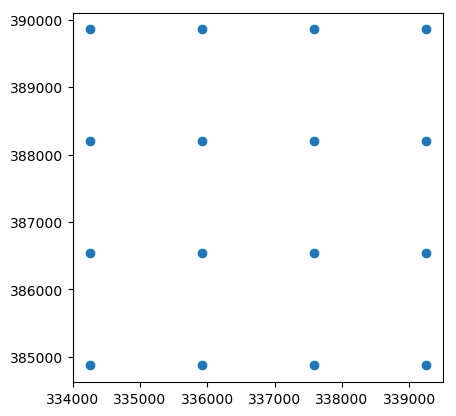

In [96]:
# plot this subset
# gdf_dtm_clipped.plot("z", cmap="Blues")
print(gdf_dtm_clipped.shape)
gdf_dtm_clipped.plot()
plt.show()
# if a pixel is outside the case study area, it is assign with a infinity value


In [ ]:
df_distance['constrained'] = ??

In [ ]:
# The distance matrix required by spopt is a M*N matrix, with M rows and N columns corresponding to demands and sites
df_distance_pivot_constrained = pd.pivot_table(df_distance, values='constrained', index=['demand_id'],
                    columns=['site_id'], aggfunc=np.sum)

In [ ]:
print(df_distance_pivot_constrained.index)
print(df_distance_pivot_constrained.columns)

In [ ]:
# save as Euclidean_distance_site_demand.csv
file_distance_cons = 'distance_matrix_demand_site_constrained.csv'
df_distance_pivot_constrained.to_csv(file_distance_cons)

In [ ]:
array_distance_Eudlidean = utilities.read_distance_matrix_as_np_array(file_distance_cons)
assert(array_distance_Eudlidean.shape == (1710, 93))

## Save distance dataframe

In [ ]:
df_distance.to_csv('distance_dataframe.csv')